## Importing Required Packages

In [1]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import pandas as pd
import numpy as np
import os
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Defining Requried Functions

In [2]:
def encodings(input_image, model, number):
    start_time = time.time()
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)
    
    if(number == 0):
        avg_pool = torch.nn.AdaptiveAvgPool2d((2,2))
        output = avg_pool(output)
        output = output.flatten().reshape((1,1024))
        
    elif(number == 1):
        avg_pool = torch.nn.AdaptiveAvgPool2d((1,1))
        output = avg_pool(output)
        output = output.reshape((1,1,2208))
        avg_pool = torch.nn.AdaptiveAvgPool1d(1000)
        output = avg_pool(output)
        output = output.flatten().reshape((1,1000))
        
    elif(number == 2):
        output = output.flatten().reshape((1,1024))
    
    elif(number == 3 or number == 4):
        output = output.reshape((1,1,2048))
        avg_pool = torch.nn.AdaptiveAvgPool1d(output_size=(1000))
        output = avg_pool(output)
        output = output.flatten().reshape((1,1000))
        
    else:
        output = avg_pool(output)
        output = output.flatten().reshape((1,1024))
    
    
    end = time.time()
    hours, rem = divmod(end-start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("total time taken = {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return output

In [3]:
def k_nn(tensor_data, output, metric):
    start_time = time.time()
    data = []
    
    distance_loss = torch.zeros(3).to('cuda')
    similarity_loss = torch.zeros(3).to('cuda')
    
    if(metric == 'distance'):
        #implementing KNN using distance metric
        dist = torch.norm(tensor_data - output, dim=1, p=None)
        knn = dist.topk(3, largest=False)
        data = knn.indices.to('cpu').numpy()
    
    else:
        cosine_similarity_output = torch.cosine_similarity(tensor_data, output, dim=1, eps=1e-6)
        cso = cosine_similarity_output.topk(3, largest = True)
        data = cso.indices.to('cpu').numpy()
        
    
    end = time.time()
    hours, rem = divmod(end-start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print("total time taken = {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    return data

In [4]:
def ingeredient_Inforation(data):
    test =data.split("{'text': '")[1:]
    ingredients = []
    for ingre in test:
        ingredients.append(ingre.split("'}")[0])
    return ingredients

def instruction_Inforation(data):
    test =data.split("{\'text\': \'")[1:]
    instructions = []
    count = 1
    for instruction in test:
        instructions.append('step '+ str(count) + ' :  '+instruction.split("'}")[0])
        count = count+1
    return instructions

## Give query Image

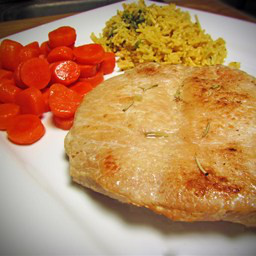

In [5]:
input_image = Image.open('data/querydata/resnext/000ad38272_b4671c60e5.jpg')
display(input_image)

## Choose the Model

In [6]:
# choose the number 0- alexnet, 1- denseNet, 2- GoogleNet, 3- resNet, 4- ResneXt, 5- VGG

number = 4
availble_path = ['alex_encoding','densenet_encoding', 'googlenet_encoding', 'resnet_encoding',
                 'resnext_encoding', 'vgg_encoding']
img_encoding_path = availble_path[number]

model = None

if(number == 0):
    alexnet = models.alexnet(progress = True, pretrained = True)
    model= torch.nn.Sequential(*(list(alexnet.children())[:-2]))
elif (number == 1):
    densenet161 = models.densenet161(pretrained=True, progress=True)
    model = torch.nn.Sequential(*(list(densenet161.children())[:-1]))
elif (number == 2):
    googleNet = models.googlenet(pretrained=True, progress=True)
    model = torch.nn.Sequential(*(list(googleNet.children())[:-1]))
elif (number == 3):
    resnet152 = models.resnet152(pretrained=True, progress=True)
    model = torch.nn.Sequential(*(list(resnet152.children())[:-1]))
elif (number == 4):
    resnext = torch.hub.load('pytorch/vision:v0.6.0', 'resnext101_32x8d', pretrained=True)
    model = torch.nn.Sequential(*(list(resnext.children())[:-1]))
else:
    vgg19 = models.vgg19_bn(pretrained=True, progress=True)
    model = torch.nn.Sequential(*(list(vgg19.children())[:-2]))

Using cache found in C:\Users\balag/.cache\torch\hub\pytorch_vision_v0.6.0


## Generate Encoding for Query Image

In [7]:
output = encodings(input_image, model, number)

total time taken = 00:00:07.17


## Loading Pre generated Encodings

In [8]:
start_time = time.time()

df = pd.read_csv('data/'+ img_encoding_path +'/encoding_file.csv',)
numpy_data = df[df.columns[2:]].to_numpy(dtype=np.float64)
tensor_data = torch.from_numpy(numpy_data).float().to(device)
del(numpy_data)

end = time.time()
hours, rem = divmod(end-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("total time taken = {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

## Retriving Similar Images using K-NN (3-NN)

In [9]:
# choose metric

metric  = ['distance','cosine_similarity'][1]
data = k_nn(tensor_data, output, metric)
top1_img = df[['id','image_id']].iloc[data[0]]
top2_img = df[['id','image_id']].iloc[data[1]]
top3_img = df[['id','image_id']].iloc[data[2]]
#del(tensor_data,output,df)

total time taken = 00:00:00.16


In [10]:
data

array([166326,  17068, 249842], dtype=int64)

In [11]:
top3_img

id              e3dbb91d95
image_id    55e0fc97e7.jpg
Name: 249842, dtype: object

## Providing Information

input image :


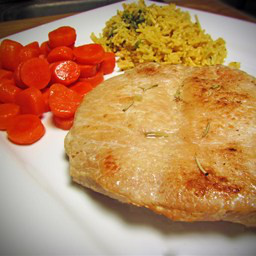

output image :


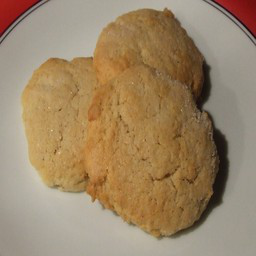

In [12]:
#first similar Image

output_image = Image.open('data/train/' + top1_img['id'] + '_' + top1_img['image_id'])
print('input image :')
display(input_image)
print('output image :')
display(output_image)

In [13]:
recipe_data = pd.read_csv('data/train_data_detail.csv')
nutritional_info = pd.read_csv('data/nutrition_status.csv')

In [14]:
top1_img['id'] in nutritional_info['id'].values

True

In [16]:
top1_data = recipe_data[['title','ingredients',
                         'instructions']].iloc[recipe_data.index[recipe_data['image_id'] == top1_img['image_id']].tolist()[0]]

print('\033[5m' + '\033[92m' + "Recipe Info - 1 " + '\033[1m','\n')
print('\033[35m' + '\033[1m' + '\033[4m' + top1_data['title'] + '\033[0m','\n')
print('\033[5m' + '\033[91m' + "Ingredients: " + '\033[1m')
ingredients = ingeredient_Inforation(top1_data['ingredients'][1:-1])
print('\033[0m')
print(*ingredients, sep='\n')
print()

print('\033[5m' + '\033[93m' + "Instructions: " + '\033[1m')
instructions = instruction_Inforation(top1_data['instructions'][1:-1])
print('\033[0m')
print(*instructions, sep='\n')
print()

print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
if(top1_img['id'] in nutritional_info['id'].values):
    nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == top1_img['id']].tolist()[0]]
    print('\033[0m',nutrition_data)
else:
    print('\033[0m', 'temporoly unavailble')
    
# if('000095fc1d' in nutritional_info['id'].values):
#     nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == '000095fc1d'].tolist()[0]]
#     print()
#     print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
#     print('\033[0m')
#     print(nutrition_data)

Recipe Info - 1  

Eggnog Cookies 

Ingredients: 

1 cup Butter, Softened
1 cup Sugar
1/2 teaspoons Nutmeg
1 teaspoon Baking Soda
1 cup Eggnog
4 cups Flour

Instructions: 

step 1 :  Beat butter and sugar until creamy.
step 2 :  Add nutmeg, soda and eggnog to the butter mixture and blend well.
step 3 :  Add flour and mix until combined.
step 4 :  Drop by teaspoonfuls onto a very lightly greased cookie sheet.
step 5 :  Dip the bottom of a glass into sugar and just slightly flatten the cookie.
step 6 :  Bake at 375 degrees for 12 minutes or until edges are golden brown.

Nutritions: 
 fat_status            orange
salt_status           orange
saturates_status         red
sugar_status             red
energy               374.422
fat                  16.8515
protein              5.48464
salt                0.302061
saturates            10.2942
sugars               18.7737
Name: 8285, dtype: object


input image :


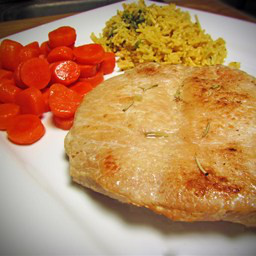

output image :


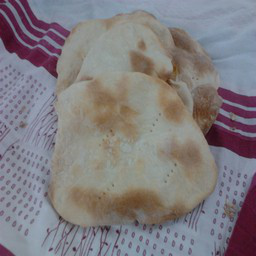

In [17]:
#second similar Image

output_image = Image.open('data/train/' + top2_img['id'] + '_' + top2_img['image_id'])
print('input image :')
display(input_image)
print('output image :')
display(output_image)

In [19]:
top2_data = recipe_data[['title','ingredients',
                         'instructions']].iloc[recipe_data.index[recipe_data['image_id'] == top2_img['image_id']].tolist()[0]]

print('\033[5m' + '\033[92m' + "Recipe Info - 1 " + '\033[1m','\n')
print('\033[35m' + '\033[1m' + '\033[4m' + top2_data['title'] + '\033[0m','\n')
print('\033[5m' + '\033[91m' + "Ingredients: " + '\033[1m')
ingredients = ingeredient_Inforation(top2_data['ingredients'][1:-1])
print('\033[0m')
print(*ingredients, sep='\n')
print()

print('\033[5m' + '\033[93m' + "Instructions: " + '\033[1m')
instructions = instruction_Inforation(top2_data['instructions'][1:-1])
print('\033[0m')
print(*instructions, sep='\n')
print()

print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
if(top2_img['id'] in nutritional_info['id'].values):
    nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == top2_img['id']].tolist()[0]]
    print('\033[0m', nutrition_data)
else:
    print('\033[0m', 'temporoly unavailble')
    
# if('000095fc1d' in nutritional_info['id'].values):
#     nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == '000095fc1d'].tolist()[0]]
#     print()
#     print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
#     print('\033[0m')
#     print(nutrition_data)

Recipe Info - 1  

Carol's Easy Pita Bread 

Ingredients: 

2 cups flour
2 14 teaspoons quick-rising yeast
12 teaspoon salt
1 14 cups hot water (but not boiling)
1 -1 12 cup flour

Instructions: 

step 1 :  Combine first four ingredients in a large bowl.
step 2 :  Beat well about 1 minute.
step 3 :  Then mix in the remaining flour, using just enough to make a soft, sticky dough.
step 4 :  Turn out on floured board and continue to knead for 5 minutes.
step 5 :  Divide into 8 balls.
step 6 :  Roll out each one to about 1/4 inch thick and 6 inches in diameter.
step 7 :  Let rise in warm place for 25-35 minutes .
step 8 :  Bake at 450 for 4 min, and then turn over for 4 more minutes or until lightly browned.
step 9 :  Wrap immediately in a dishtowel for 3 or 4 minutes.

Nutritions: 
 temporoly unavailble


input image :


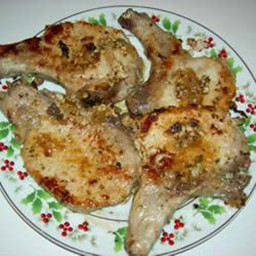

output image :


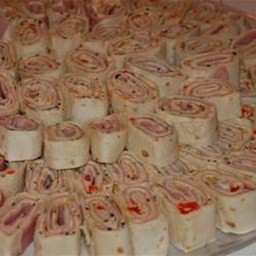

In [27]:
#third similar Image

output_image = Image.open('data/train/' + top3_img['id'] + '_' + top3_img['image_id'])
print('input image :')
display(input_image)
print('output image :')
display(output_image)

In [20]:
top3_data = recipe_data[['title','ingredients',
                         'instructions']].iloc[recipe_data.index[recipe_data['image_id'] == top3_img['image_id']].tolist()[0]]

print('\033[5m' + '\033[92m' + "Recipe Info - 1 " + '\033[1m','\n')
print('\033[35m' + '\033[1m' + '\033[4m' + top3_data['title'] + '\033[0m','\n')
print('\033[5m' + '\033[91m' + "Ingredients: " + '\033[1m')
ingredients = ingeredient_Inforation(top3_data['ingredients'][1:-1])
print('\033[0m')
print(*ingredients, sep='\n')
print()

print('\033[5m' + '\033[93m' + "Instructions: " + '\033[1m')
instructions = instruction_Inforation(top3_data['instructions'][1:-1])
print('\033[0m')
print(*instructions, sep='\n')
print()

print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
if(top3_img['id'] in nutritional_info['id'].values):
    nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == top3_img['id']].tolist()[0]]
    print('\033[0m',nutrition_data)
else:
    print('\033[0m', 'temporoly unavailble')
    
# if('000095fc1d' in nutritional_info['id'].values):
#     nutrition_data = nutritional_info[nutritional_info.columns[1:]].iloc[nutritional_info.index[nutritional_info['id'] == '000095fc1d'].tolist()[0]]
#     print()
#     print('\033[5m' + '\033[94m' + "Nutritions: " + '\033[1m')
#     print('\033[0m')
#     print(nutrition_data)

Recipe Info - 1  

Amish Breakfast Casserole 

Ingredients: 

1 lb bacon, diced
1 medium sweet onion, chopped
6 eggs, lightly beaten
4 cups frozen hash brown potatoes, thawed
2 cups shredded cheddar cheese
1 12 cups 4% cottage cheese
1 14 cups shredded swiss cheese
salt and pepper

Instructions: 

step 1 :  In a large skillet, cook bacon and onion until bacon is crisp; drain.
step 2 :  In a large bowl, combine the remaining ingredients; stir in bacon mixture.
step 3 :  Transfer to a greased 13-in.
step 4 :  x 9-in.
step 5 :  baking dish.
step 6 :  Bake, uncovered, at 350 for 35-40 minutes or until a knife inserted near the center comes out clean.
step 7 :  Let stand for 10 minutes before cutting.

Nutritions: 
 temporoly unavailble
